In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix


# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((512,512)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TEST/', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=4)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=16):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, out_channels = 32, kernel_size=3, stride=2, padding=1), #224
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),#112
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),#56
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.4)
            #nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=1), #28
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p=0.5)
            
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4 * 8 * 8, 1000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): PReLU(num_parameters=1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): PReLU(num_parameters=1)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 200)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Append batch prediction results
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 10 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 12.005% | Train Loss => 2.76062
Test Acc.  => 16.163% | Test Loss  => 2.74816

Epoch: 10
Train Acc. => 16.006% | Train Loss => 2.48590
Test Acc.  => 16.519% | Test Loss  => 2.48339

Epoch: 20
Train Acc. => 21.734% | Train Loss => 2.25552
Test Acc.  => 27.176% | Test Loss  => 2.13376

Epoch: 30
Train Acc. => 39.113% | Train Loss => 1.67212
Test Acc.  => 43.694% | Test Loss  => 1.58106

Epoch: 40
Train Acc. => 53.884% | Train Loss => 1.27597
Test Acc.  => 51.510% | Test Loss  => 1.25563

Epoch: 50
Train Acc. => 63.240% | Train Loss => 1.02402
Test Acc.  => 53.464% | Test Loss  => 1.14695

Epoch: 60
Train Acc. => 67.713% | Train Loss => 0.88054
Test Acc.  => 63.588% | Test Loss  => 0.94003

Epoch: 70
Train Acc. => 74.990% | Train Loss => 0.67664
Test Acc.  => 68.917% | Test Loss  => 0.83012

Epoch: 80
Train Acc. => 79.894% | Train Loss => 0.56640
Test Acc.  => 73.002% | Test Loss  => 0.75507

Epoch: 90
Train Acc. => 82.542% | Train Loss => 0.47379
Test Acc.  => 73.

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[15929   163   287     2     4   433    48   206    61   126     4   183
    519   105   130     0]
 [ 1424  5571    84   864     3   614     6   276   185    75     1   293
      1     1     2     0]
 [ 1468    89  5468    86   224   124  1067     4   717     0   132    12
      1     0     8     0]
 [  609  2350    29   507     0   202     0    51    55    72     0   124
      0     0     1     0]
 [  681     5   185     0  5860     4   208     0   412     0     7     1
      0     0    33     4]
 [ 1946   460   503    45    15  5010   216   119   457     0    20     8
      0     1     0     0]
 [  639     8   796     5  1020     9  2582     0   395     0   106     1
      0     0    39     0]
 [ 1089   457    48    21     0   388     0  4120   104    35     0   137
      1     0     0     0]
 [ 1059    39   336     2   318    91    49     0  8496     0     0     7
      0     0     3     0]
 [  645   143     1    38     0     0     0   153    10  2916     0   506
    173    14    

<AxesSubplot:>

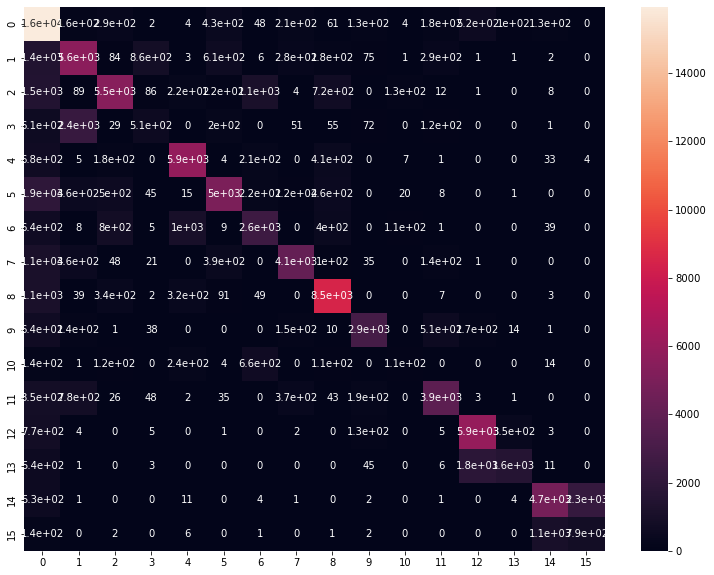

In [9]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=True, ax=ax)

In [10]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[87.52197802 59.26595745 58.17021277 12.675      79.18918919 56.93181818
 46.10714286 64.375      81.69230769 63.39130435  7.71428571 62.20967742
 82.27777778 39.175      62.42105263 39.65      ]


In [11]:
"""
plt.plot(steps, lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate values")
plt.title("learning rate's curve")
plt.show()
"""

'\nplt.plot(steps, lrs)\nplt.xlabel("epoch")\nplt.ylabel("learning rate values")\nplt.title("learning rate\'s curve")\nplt.show()\n'

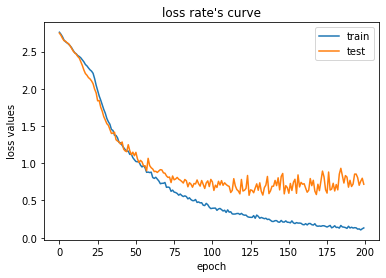

In [12]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

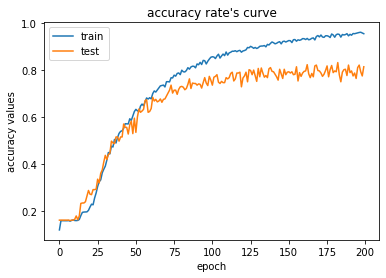

In [13]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [14]:
torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Saved_Network/dict_Linh_network_4th_try_16species")

In [15]:
torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Saved_Network/Linh_network_entire_model_4th_try_16species")

In [16]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [17]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"

## Load Model

In [18]:
net = NewNetwork()
net.load_state_dict(torch.load('C:/Users/heuma/Desktop/Master/S10/Aurea/Saved_Network/dict_Linh_network_4th_try_16species'))

<All keys matched successfully>

In [19]:
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): PReLU(num_parameters=1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): PReLU(num_parameters=1)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [20]:
transform = transforms.Compose(
    [transforms.Resize((512,512)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_20-80/TEST/', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=4)